In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch

In [2]:
np.random.seed(45)
num_samples = 40
    
# Generate data
x1 = np.random.uniform(-1, 1, num_samples)
f_x = 3*x1 + 4
eps = np.random.random(num_samples)
y = f_x + eps

In [3]:
x1 = torch.tensor(x1, dtype=torch.float32).reshape(-1, 1)
x1 = torch.hstack((x1, torch.ones_like(x1)))
y = torch.tensor(y, dtype=torch.float32)
theta = torch.randn(x1.shape[1], requires_grad=True)

print("The shape of x1 is: ", x1.shape)
print("The shape of y is: ", y.shape)
print("The shape of theta is: ", theta.shape)

The shape of x1 is:  torch.Size([40, 2])
The shape of y is:  torch.Size([40])
The shape of theta is:  torch.Size([2])


In [4]:
y_pred = x1@theta
loss = torch.nn.MSELoss()(y_pred, y)
print("Gradient before backward pass: ", theta.grad)
loss.backward()
print("Gradient after backward pass: ", theta.grad)
true_gradient = theta.grad.detach().clone()

Gradient before backward pass:  None
Gradient after backward pass:  tensor([-0.9687, -8.7727])


In [5]:
gradient = []
theta.grad.zero_()
for i in range(len(x1)):
    y_pred_i = x1@theta
    loss_s = torch.nn.MSELoss()(y_pred_i[i], y[i])
    loss_s.backward(retain_graph=True)
    gradient.append(theta.grad.detach().clone())
    theta.grad.zero_()

In [6]:
gradient = torch.stack(gradient)
gradient = gradient.mean(dim=0)
print("Gradient using stochastic method: ", gradient)
print("Gradient after backward pass: ", true_gradient)

Gradient using stochastic method:  tensor([-0.9687, -8.7727])
Gradient after backward pass:  tensor([-0.9687, -8.7727])


In [7]:
def model(x, theta):
    return x@theta
loss_fn = torch.nn.MSELoss()


In [8]:
def full_batch_gd(x1:torch.tensor,y:torch.tensor,lr:float, epochs:int):
    '''
    Performs the gradient descent using the full batch method

    Input:
    x1: torch.Tensor: The input features
    y: torch.Tensor: The target variable
    theta: torch.Tensor: The parameters
    lr: float: The learning rate
    epochs: int: The number of epochs

    Returns:
    theta: torch.Tensor: The updated parameters
    '''
    theta = torch.ones(x1.shape[1], requires_grad=True)
    theta_hist, loss_hist = [], []
    theta_hist.append(theta.detach().clone())
    loss_hist.append(loss_fn(model(x1,theta),y).item())
    for epoch in range(epochs):
        y_pred = model(x1, theta)
        loss = loss_fn(y_pred, y)
        loss.backward()

        # Update parameters
        with torch.no_grad():
            theta -= lr*theta.grad

        # Save history
        theta_hist.append(theta.detach().clone())
        loss_hist.append(loss.item())

        # Zero gradients
        theta.grad.zero_()

    return theta_hist, loss_hist


In [9]:
def stochastic_gradient_descent(x1:torch.tensor, y:torch.tensor, lr:float, epochs:int):
    '''
    Performs the gradient descent using the stochastic method

    Input:
    x1: torch.Tensor: The input features
    y: torch.Tensor: The target variable
    theta: torch.Tensor: The parameters
    lr: float: The learning rate
    epochs: int: The number of epochs

    Returns:
    theta: torch.Tensor: The updated parameters
    '''
    theta = torch.ones(x1.shape[1], requires_grad=True)
    theta_hist, loss_hist = [], []
    theta_hist.append(theta.detach().clone())
    loss_hist.append(loss_fn(model(x1,theta),y).item())
    for epoch in range(epochs):
        for i in range(len(x1)):
            Y_pred = model(x1, theta)
            loss = loss_fn(Y_pred[i], y[i])
            
            loss.backward(retain_graph=True)
            with torch.no_grad():
                theta -= lr*theta.grad
            theta.grad.zero_()
            theta_hist.append(theta.detach().clone())
            loss_hist.append(loss.item())
    return theta_hist, loss_hist
            

In [10]:
def mini_batch_gradient_descent(x1:torch.tensor, y:torch.tensor, lr:float, epochs:int, batch_size:int):
    '''
    Performs the gradient descent using the mini batch method

    Input:
    x1: torch.tensor: The input features
    y: torch.tensor: The target variable
    theta: torch.tensor: The parameters
    lr: float: The learning rate
    epochs: int: The number of epochs
    batch_size: int: The size of the batch

    Returns:
    theta: torch.tensor: The updated parameters
    '''
    theta = torch.ones(x1.shape[1], requires_grad=True)
    theta_hist, loss_hist = [], []
    theta_hist.append(theta.detach().clone())
    loss_hist.append(loss_fn(model(x1,theta),y).item())
    for epoch in range(epochs):
        for i in range(0, len(x1), batch_size):
            x_batch = x1[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            y_pred = model(x_batch, theta)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            with torch.no_grad():
                theta -= lr*theta.grad
            theta.grad.zero_()
            theta_hist.append(theta.detach().clone())
            loss_hist.append(loss.item())
    return theta_hist, loss_hist

In [11]:
epochs = 15
batch_size = 5 
lr = 0.01
fb_gd = full_batch_gd(x1, y, lr, epochs)
sgd = stochastic_gradient_descent(x1, y,  lr, epochs)
mb_gd = mini_batch_gradient_descent(x1, y, lr, epochs, batch_size)

In [12]:
epsilon = 0.001
min_loss_fb = min(fb_gd[1])
min_loss_sgd = min(sgd[1])
min_loss_mb = min(mb_gd[1])

for(i, loss) in enumerate(fb_gd[1]):
    if loss - min_loss_fb < epsilon:
        min_loss_fb_epoch = i
        break

for(i, loss) in enumerate(sgd[1]):
    if loss - min_loss_sgd < epsilon:
        min_loss_sgd_epoch = i
        break

for(i, loss) in enumerate(mb_gd[1]):
    if loss - min_loss_mb < epsilon:
        min_loss_mb_epoch = i
        break
print("Full batch method Iterations: ", min_loss_fb_epoch, ", Full batch method epochs: ", min_loss_fb_epoch)
print("Stochastic method Iterations: ", min_loss_sgd_epoch, ", Stochastic method epochs: ", min_loss_sgd_epoch/len(x1))
print("Mini batch method Iteration: ", min_loss_mb_epoch, ", Mini batch method epochs: ", min_loss_mb_epoch/len(x1)*batch_size)


Full batch method Iterations:  15 , Full batch method epochs:  15
Stochastic method Iterations:  48 , Stochastic method epochs:  1.2
Mini batch method Iteration:  117 , Mini batch method epochs:  14.625


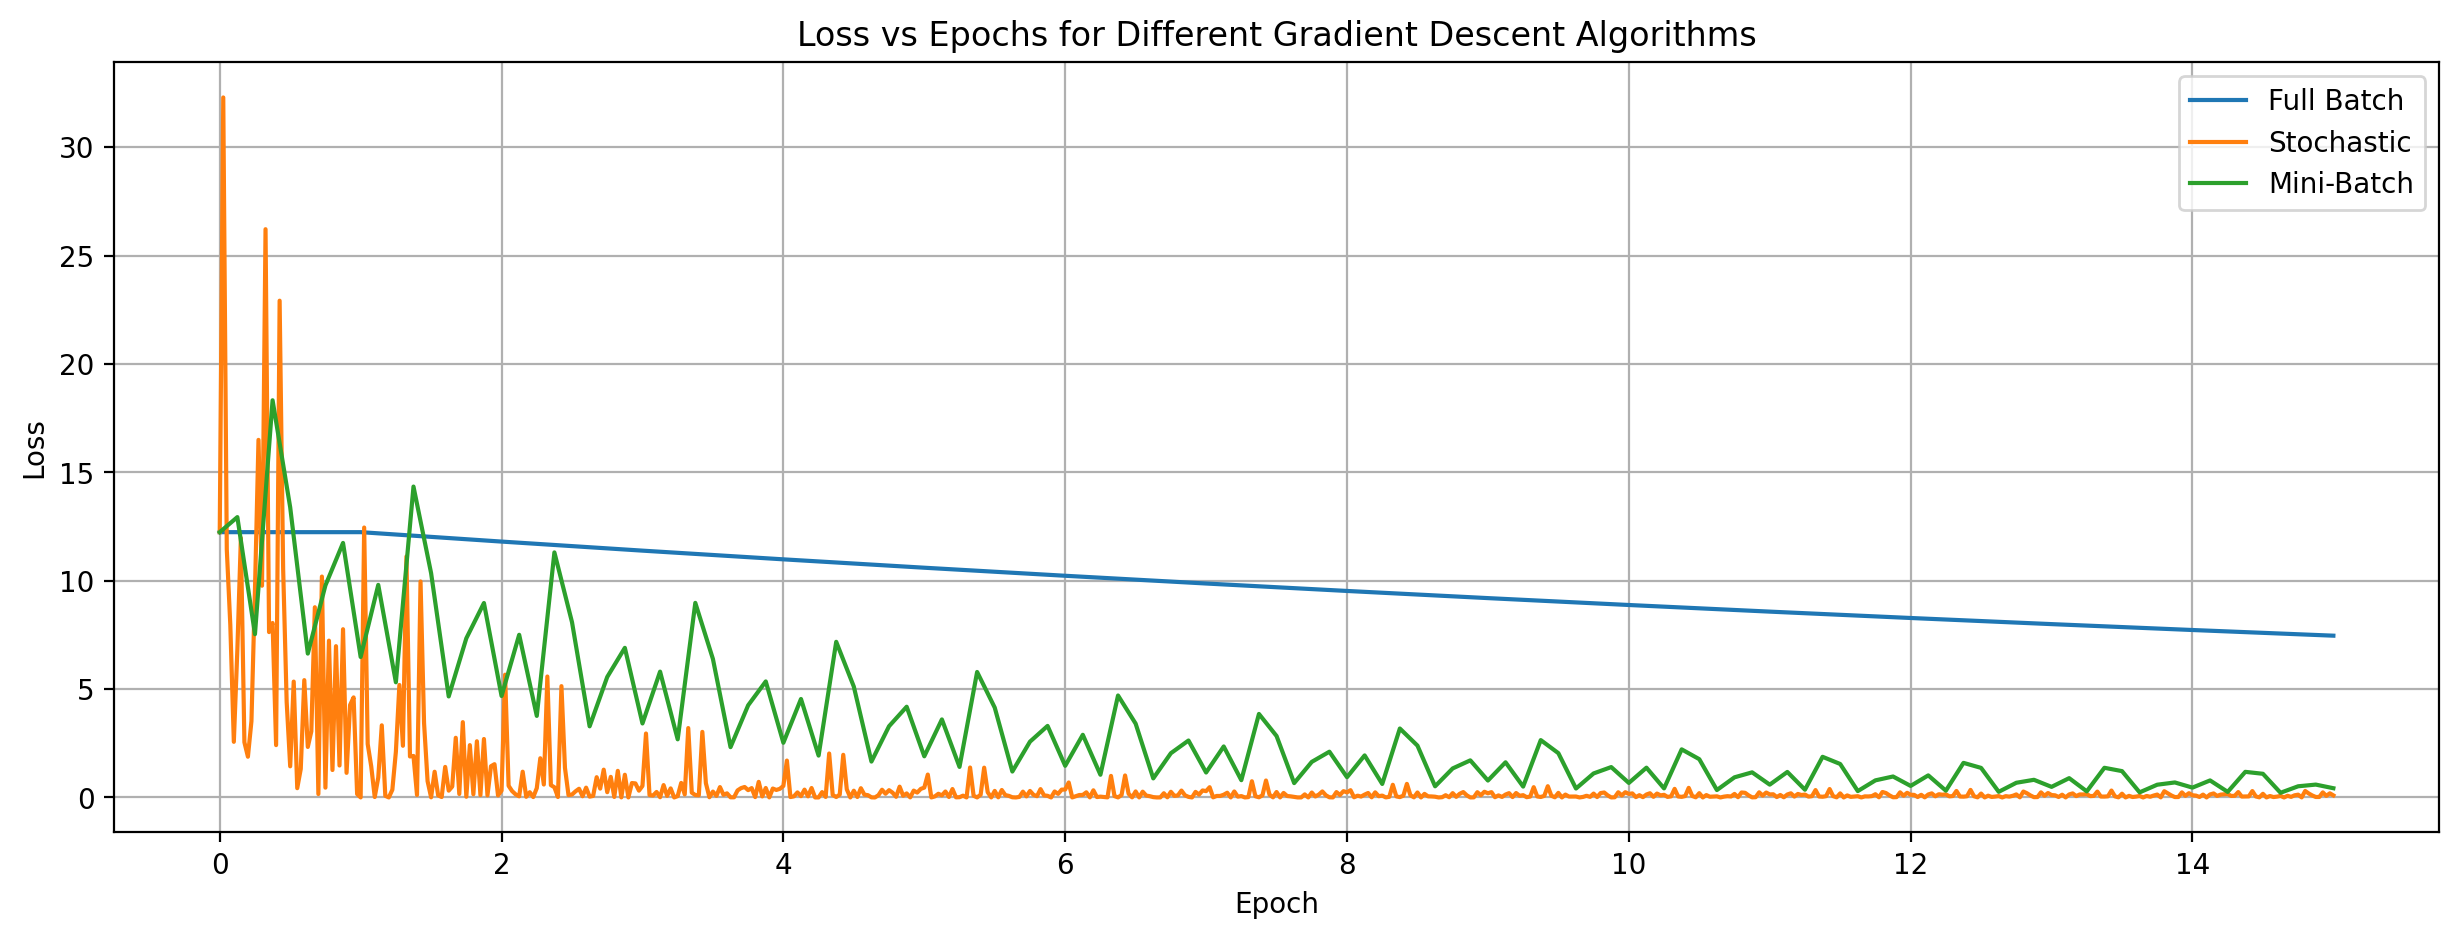

In [13]:
x_sgd = np.linspace(0,15,15*len(x1)+1)
x_mb = np.linspace(0,15,15*int(len(x1)/batch_size)+1)
x_fb = np.linspace(0,15,16)
plt.figure(figsize=(15,5))
plt.plot(x_fb,fb_gd[1], label = "Full Batch")
plt.plot(x_sgd, sgd[1], label="Stochastic")
plt.plot(x_mb,mb_gd[1], label="Mini-Batch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs for Different Gradient Descent Algorithms")
plt.grid()
plt.legend()
plt.show()


(16, 2) (16,)


C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_23692\1213585613.py:43: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point.set_data(theta_0, theta_1)


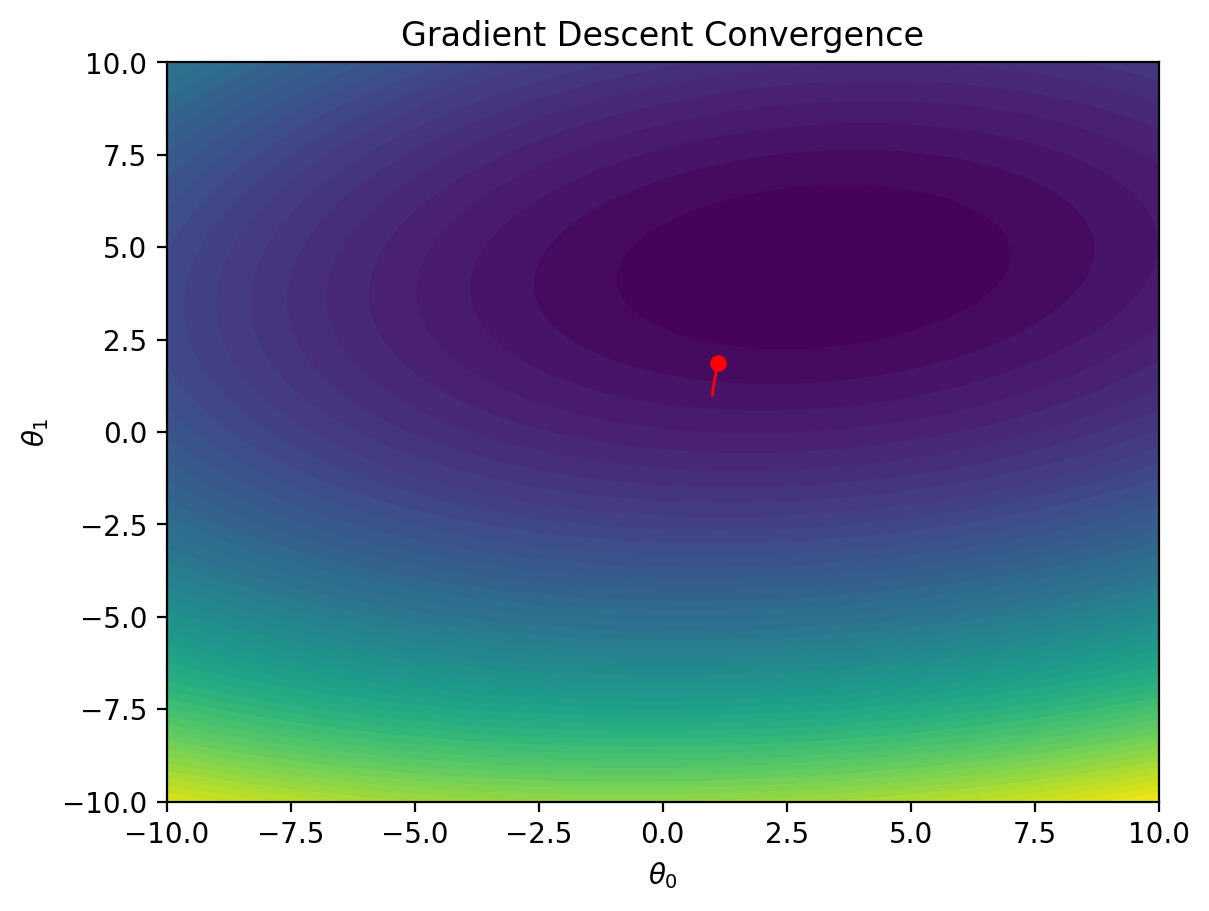

In [14]:
theta_vals=np.array(fb_gd[0])
loss_vals = np.array(fb_gd[1])
print(theta_vals.shape, loss_vals.shape)

# Generate a grid for theta_0 and theta_1 values to create the contour plot
theta_0_vals = np.linspace(-10, 10, 100)
theta_1_vals = np.linspace(-10, 10, 100)
theta_0_grid, theta_1_grid = np.meshgrid(theta_0_vals, theta_1_vals)

# Calculate the loss for each point in the grid to create the contour plot
loss_grid = np.zeros_like(theta_0_grid)
for i in range(theta_0_grid.shape[0]):
    for j in range(theta_0_grid.shape[1]):
        theta_tensor = torch.tensor([theta_0_grid[i, j], theta_1_grid[i, j]], dtype=torch.float32).view(-1, 1)
        y_pred = model(x1, theta_tensor).squeeze()  # Remove singleton dimension
        loss = loss_fn(y_pred, y)
        loss_grid[i, j] = loss.item()

# Set up the figure and axis
fig, ax = plt.subplots()

# Create the contour plot
contour = ax.contourf(theta_0_grid, theta_1_grid, loss_grid, levels=50, cmap='viridis')
ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\theta_1$')
ax.set_title('Gradient Descent Convergence')

# Create a point and a line to represent the path of theta updates
point, = ax.plot([], [], 'ro', markersize=5)
line, = ax.plot([], [], 'r-', linewidth=1)

# Initialize the animation
def init():
    point.set_data([], [])
    line.set_data([], [])
    return point, line

# Update function for animation
def update(frame):    
    if frame < len(theta_vals):
        # Extract theta_0 and theta_1 values
        theta_0, theta_1 = theta_vals[frame]
        point.set_data(theta_0, theta_1)
        
        # Update the path line
        line.set_data(theta_vals[:frame + 1, 0], theta_vals[:frame + 1, 1])
    return point, line

# Create the animation with the correct number of frames
ani = animation.FuncAnimation(fig, update, frames=len(theta_vals), init_func=init, blit=True, interval=500)

# Save the animation as a GIF (requires PillowWriter)
ani.save('Full_Batch.gif', writer='pillow', fps=2)

# Display the plot
plt.show()


(601, 2) (601,)


C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_23692\745128120.py:43: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point.set_data(theta_0, theta_1)


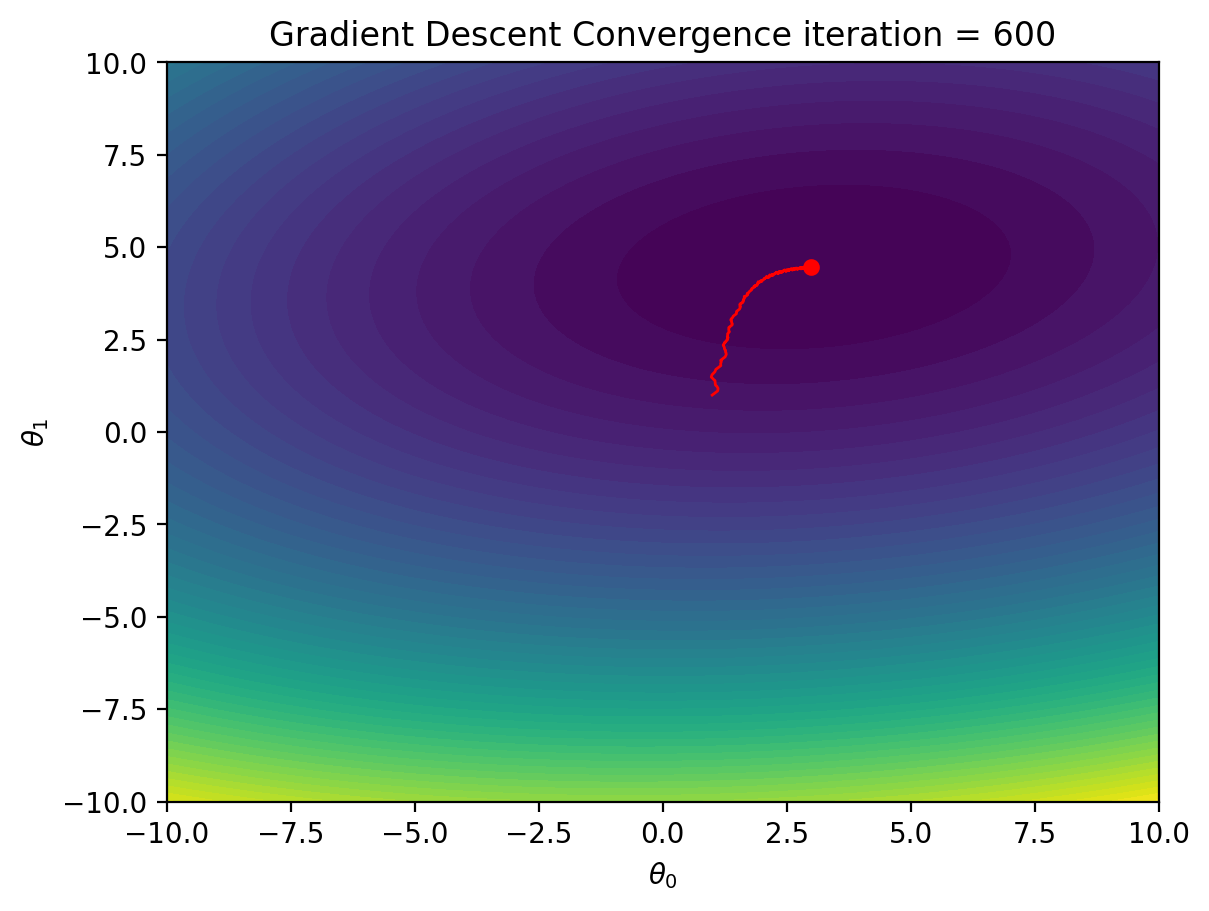

In [18]:
theta_vals=np.array(sgd[0])
loss_vals = np.array(sgd[1])
print(theta_vals.shape, loss_vals.shape)

# Generate a grid for theta_0 and theta_1 values to create the contour plot
theta_0_vals = np.linspace(-10, 10, 100)
theta_1_vals = np.linspace(-10, 10, 100)
theta_0_grid, theta_1_grid = np.meshgrid(theta_0_vals, theta_1_vals)

# Calculate the loss for each point in the grid to create the contour plot
loss_grid = np.zeros_like(theta_0_grid)
for i in range(theta_0_grid.shape[0]):
    for j in range(theta_0_grid.shape[1]):
        theta_tensor = torch.tensor([theta_0_grid[i, j], theta_1_grid[i, j]], dtype=torch.float32).view(-1, 1)
        y_pred = model(x1, theta_tensor).squeeze()  # Remove singleton dimension
        loss = loss_fn(y_pred, y)
        loss_grid[i, j] = loss.item()

# Set up the figure and axis
fig, ax = plt.subplots()

# Create the contour plot
contour = ax.contourf(theta_0_grid, theta_1_grid, loss_grid, levels=50, cmap='viridis')
ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\theta_1$')
ax.set_title(f'Gradient Descent Convergence iteration = 0')

# Create a point and a line to represent the path of theta updates
point, = ax.plot([], [], 'ro', markersize=5)
line, = ax.plot([], [], 'r-', linewidth=1)

# Initialize the animation
def init():
    point.set_data([], [])
    line.set_data([], [])
    return point, line

# Update function for animation
def update(frame):    
    if frame < len(theta_vals):
        # Extract theta_0 and theta_1 values
        theta_0, theta_1 = theta_vals[frame]
        point.set_data(theta_0, theta_1)
        
        # Update the path line
        line.set_data(theta_vals[:frame + 1, 0], theta_vals[:frame + 1, 1])
    ax.set_title(f'Gradient Descent Convergence iteration = {frame}')
    return point, line

# Create the animation with the correct number of frames
ani = animation.FuncAnimation(fig, update, frames=len(theta_vals), init_func=init, blit=True, interval=500)

# Save the animation as a GIF (requires PillowWriter)
ani.save('Stochastic_Gradient_Descent.gif', writer='pillow', fps=2)

# Display the plot
plt.show()


(121, 2) (121,)


C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_23692\2578656083.py:43: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point.set_data(theta_0, theta_1)


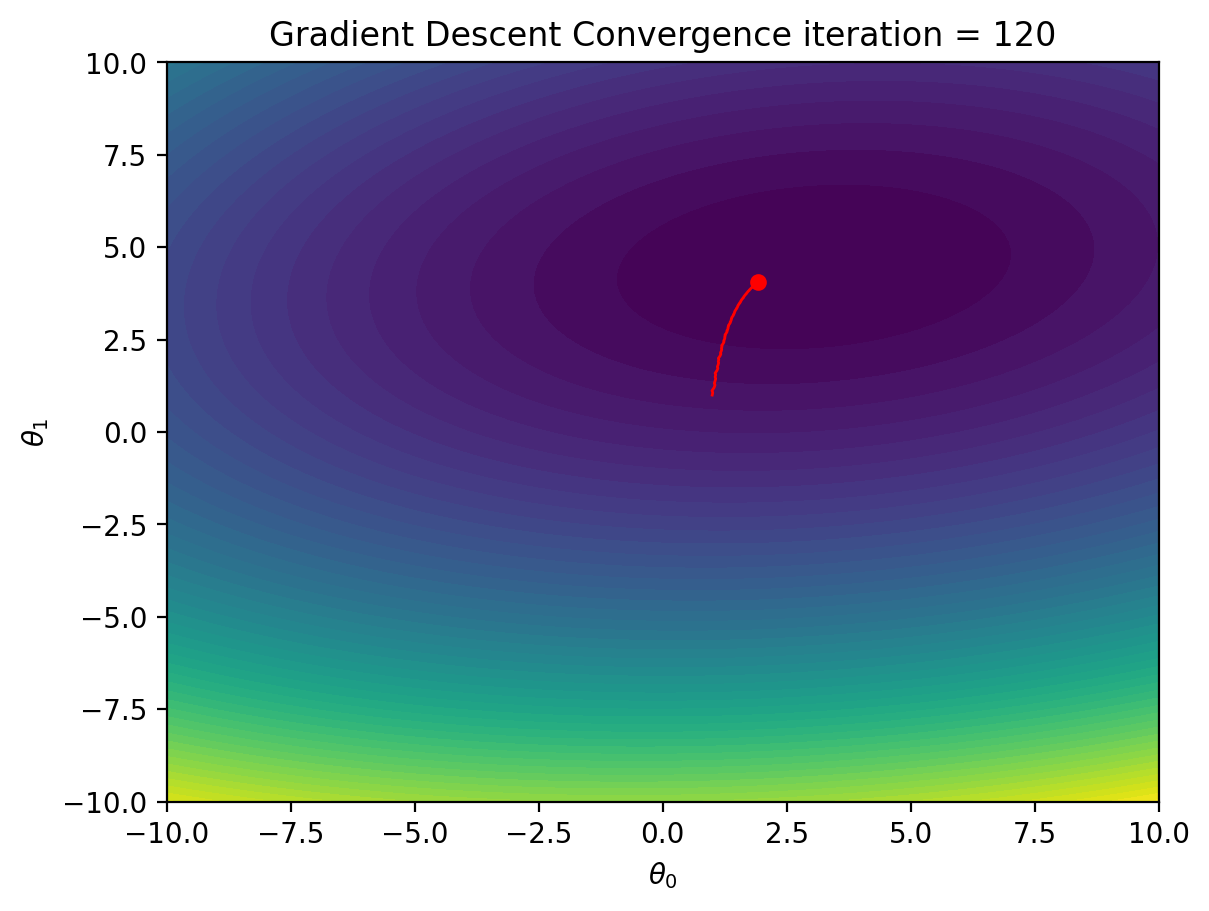

In [17]:
theta_vals=np.array(mb_gd[0])
loss_vals = np.array(mb_gd[1])
print(theta_vals.shape, loss_vals.shape)

# Generate a grid for theta_0 and theta_1 values to create the contour plot
theta_0_vals = np.linspace(-10, 10, 100)
theta_1_vals = np.linspace(-10, 10, 100)
theta_0_grid, theta_1_grid = np.meshgrid(theta_0_vals, theta_1_vals)

# Calculate the loss for each point in the grid to create the contour plot
loss_grid = np.zeros_like(theta_0_grid)
for i in range(theta_0_grid.shape[0]):
    for j in range(theta_0_grid.shape[1]):
        theta_tensor = torch.tensor([theta_0_grid[i, j], theta_1_grid[i, j]], dtype=torch.float32).view(-1, 1)
        y_pred = model(x1, theta_tensor).squeeze()  # Remove singleton dimension
        loss = loss_fn(y_pred, y)
        loss_grid[i, j] = loss.item()

# Set up the figure and axis
fig, ax = plt.subplots()

# Create the contour plot
contour = ax.contourf(theta_0_grid, theta_1_grid, loss_grid, levels=50, cmap='viridis')
ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\theta_1$')
ax.set_title(f'Gradient Descent Convergence iteration = 0')

# Create a point and a line to represent the path of theta updates
point, = ax.plot([], [], 'ro', markersize=5)
line, = ax.plot([], [], 'r-', linewidth=1)

# Initialize the animation
def init():
    point.set_data([], [])
    line.set_data([], [])
    return point, line

# Update function for animation
def update(frame):    
    if frame < len(theta_vals):
        # Extract theta_0 and theta_1 values
        theta_0, theta_1 = theta_vals[frame]
        point.set_data(theta_0, theta_1)
        
        # Update the path line
        line.set_data(theta_vals[:frame + 1, 0], theta_vals[:frame + 1, 1])
    ax.set_title(f'Gradient Descent Convergence iteration = {frame}')
    return point, line

# Create the animation with the correct number of frames
ani = animation.FuncAnimation(fig, update, frames=len(theta_vals), init_func=init, blit=True, interval=500)

# Save the animation as a GIF (requires PillowWriter)
ani.save('Mini_Batch_Gradient_Descent.gif', writer='pillow', fps=2)

# Display the plot
plt.show()


In [21]:
def gradient_descent_with_momentum(x1:torch.tensor, y:torch.tensor, lr:float, epochs:int, momentum:float):
    '''
    This function implements the gradient descent algorithm with momentum

    Input:
    x1: torch.tensor: The input features
    y: torch.tensor: The target variable
    lr: float: The learning rate
    epochs: int: The number of epochs
    momentum: float: The momentum value

    Returns:
    theta_hist: list: The history of the parameters
    loss_hist: list: The history of the loss values
    '''
    theta = torch.ones(x1.shape[1], requires_grad=True)
    theta_hist, loss_hist = [], []
    theta_hist.append(theta.detach().clone())
    loss_hist.append(loss_fn(model(x1,theta),y).item())
    v = torch.zeros_like(theta)
    for epoch in range(epochs):
        y_pred = model(x1, theta)
        loss = loss_fn(y_pred, y)
        loss.backward()
        with torch.no_grad():
            v = momentum*v + lr*theta.grad
            theta -= v
        theta_hist.append(theta.detach().clone())
        loss_hist.append(loss.item())
        theta.grad.zero_()
    return theta_hist, loss_hist, v

In [22]:
gd_m = gradient_descent_with_momentum(x1, y, lr, epochs, 0.9)
loss_gdm = gd_m[1]
theta_vals_gdm = np.array(gd_m[0])
v_gdm = gd_m[2]

In [24]:
gdm_iteration = None
for i in range(1, len(loss_gdm)):
    if loss_gdm[i] - loss_gdm[i-1] < epsilon:
        gdm_iteration = i
        break
print("Iteration for Vanilla Gradient Descent: ", min_loss_fb_epoch)
print("Iteration for Gradient Descent with Momentum: ", gdm_iteration)

Iteration for Vanilla Gradient Descent:  15
Iteration for Gradient Descent with Momentum:  1


C:\Users\Harshil Shah\AppData\Local\Temp\ipykernel_23692\2483528002.py:43: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point.set_data(theta_0, theta_1)


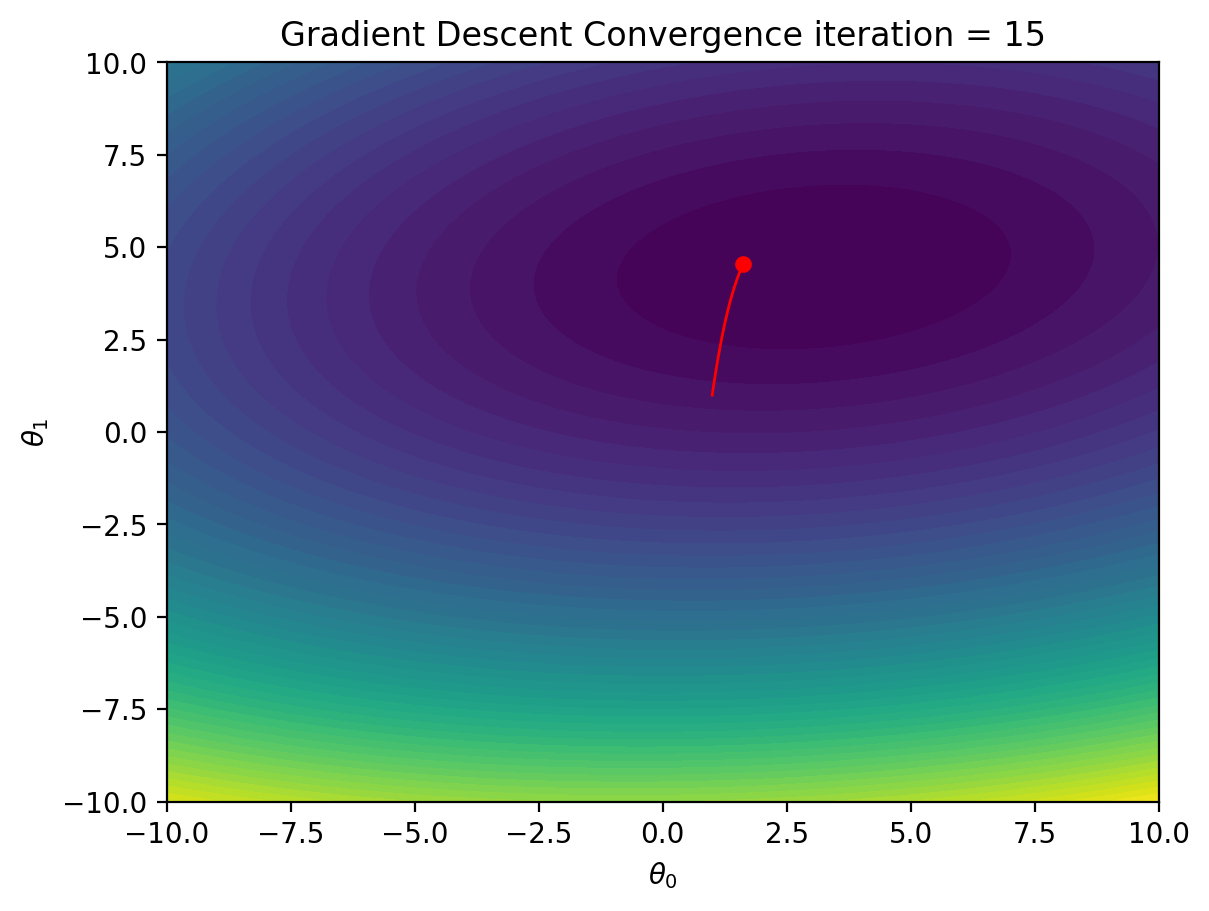

In [26]:
theta_vals=theta_vals_gdm
loss_vals = loss_gdm
# print(theta_vals.shape, loss_vals.shape)

# Generate a grid for theta_0 and theta_1 values to create the contour plot
theta_0_vals = np.linspace(-10, 10, 100)
theta_1_vals = np.linspace(-10, 10, 100)
theta_0_grid, theta_1_grid = np.meshgrid(theta_0_vals, theta_1_vals)

# Calculate the loss for each point in the grid to create the contour plot
loss_grid = np.zeros_like(theta_0_grid)
for i in range(theta_0_grid.shape[0]):
    for j in range(theta_0_grid.shape[1]):
        theta_tensor = torch.tensor([theta_0_grid[i, j], theta_1_grid[i, j]], dtype=torch.float32).view(-1, 1)
        y_pred = model(x1, theta_tensor).squeeze()  # Remove singleton dimension
        loss = loss_fn(y_pred, y)
        loss_grid[i, j] = loss.item()

# Set up the figure and axis
fig, ax = plt.subplots()

# Create the contour plot
contour = ax.contourf(theta_0_grid, theta_1_grid, loss_grid, levels=50, cmap='viridis')
ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\theta_1$')
ax.set_title(f'Gradient Descent Convergence iteration = 0')

# Create a point and a line to represent the path of theta updates
point, = ax.plot([], [], 'ro', markersize=5)
line, = ax.plot([], [], 'r-', linewidth=1)

# Initialize the animation
def init():
    point.set_data([], [])
    line.set_data([], [])
    return point, line

# Update function for animation
def update(frame):    
    if frame < len(theta_vals):
        # Extract theta_0 and theta_1 values
        theta_0, theta_1 = theta_vals[frame]
        point.set_data(theta_0, theta_1)
        
        # Update the path line
        line.set_data(theta_vals[:frame + 1, 0], theta_vals[:frame + 1, 1])
    ax.set_title(f'Gradient Descent Convergence iteration = {frame}')
    return point, line

# Create the animation with the correct number of frames
ani = animation.FuncAnimation(fig, update, frames=len(theta_vals), init_func=init, blit=True, interval=500)

# Save the animation as a GIF (requires PillowWriter)
ani.save('Gradient Descent with Momentum.gif', writer='pillow', fps=2)

# Display the plot
plt.show()
